# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

## **Import packages, data, and Initial EDA**

In [1]:
#import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats.mstats import zscore
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
%matplotlib inline

In [2]:
#import data
df = pd.read_csv('data/human_body_temperature.csv')

## EDA-investigate the dataset:

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


There are only three features, two are continuous, one categorical.

In [4]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


Data ranges: **96.3-100.8** temp, **57.0-89.0** heart rate
Mean for temp is **98.249**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


There are **130** records, and no missing data.
## On to the questions...

### **Question 1: Is the distribution of body temperatures normal?**

To begin, let's state the Null and Alternate Hypothesis:
<br>**Null Hypothesis:** Body temperatures are normally distributed
<br>**Alternate Hypothesis:** Body temperature is NOT normally distributed
<br>Let's make a histagram of the temperature data to investigate this:

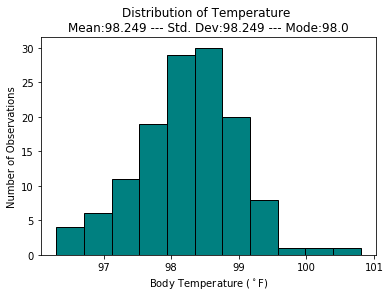

In [6]:
n_bins = int(np.sqrt(len(df['temperature'])))
_ = plt.hist(df['temperature'], color='teal', edgecolor='black',bins=n_bins)
_ = plt.xlabel('Body Temperature ($^\circ$F)')
_ = plt.ylabel('Number of Observations')
_ = plt.title(('Distribution of Temperature \nMean:'+('{:3.6}'.format(str(np.mean(df['temperature']))))+
           ' --- Std. Dev:'+('{:1.6}'.format(str(np.mean(df['temperature']))))+
          ' --- Mode:'+('{:3.6}'.format(str(df.temperature.sort_values().mode().values[0])))))
plt.show()

The plot looks somewhat like a normal distribution, but to further investigate if this is a normal distribution, let's use the normaltest method available in scipy.stats.
The normaltest of a distribution returns a tuple: the first value is the chi-squared statistic and the second is 
the p-value. If the p-value is above a certain threshold (let's use 0.05), we can assume that the distribution is 
a normal distribution.

In [7]:
stats.normaltest(df['temperature'])

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

The p-value obtained is approximately 0.258, greater than 0.05. This indicates that the null hypothesis cannot be rejected.

Another way to test for normality is to calculate an Empirical Cumulative Distribution Function (ECDF) to compare the data
to a normally distributed curve.

Define a function to calculate the ECDF and plot the sample cumulative distribution vs. the theoretical normal:

In [8]:
def ecdf(df):
    """Compute ECDF for a one-dimensional array of measurements.  Return X and Y."""

    # Number of data points:
    n = len(df)

    # x-data for the ECDF:
    x = np.sort(df)

    # y-data for the ECDF:
    y = np.arange(1, n+1) / n

    return x, y

Now calculate the mean and standard deviation from the Temperature data to model and plot a theoretical normal distribution for comparison to our ECDF:

In [9]:
#sample mean and std dev
mean_temp = np.mean(df['temperature'])
std_temp = np.std(df['temperature'])

#generate 10,000 samples at a normal distribution using sample mean and std dev
temp_samples = np.random.normal(mean_temp, std_temp, size=10000)

#generate x,y values of sample and normal distribution
x_temp, y_temp = ecdf(df['temperature'])
x_theor, y_theor = ecdf(temp_samples)

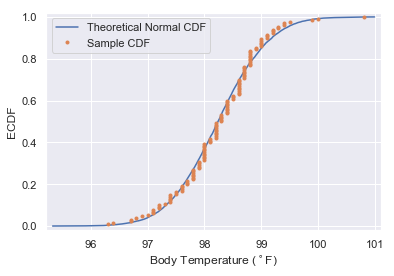

In [10]:
#Graph the ECDF and Theoretical Normal Distribution data
sns.set()
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x_temp, y_temp, marker='.', linestyle='none')
_ = plt.xlabel('Body Temperature ($^\circ$F)')
_ = plt.ylabel('ECDF')
_ = plt.legend(['Theoretical Normal CDF', 'Sample CDF'])
plt.margins(0.02)
plt.show()

The blue solid line represents the empirical cumulative distribution of body temperatures, given the sample mean 
and sample standard deviation, and modeled as a normal distribution.

The orange plotted data represent the ECDF of body temperatures from the sample data drawn from the Tempterature
data. The ECDF of the sample data closely alignes with the ECDF Theoretical Normal CDF distribution, indicating the data is normally distributed.


Using this plot,let's see if our sample set follows the 68% and 95% rule (the percentage of data that lies within 2 and 4 
standard deviations around the mean, respectively). 

In [11]:
print('68% of the observations below a body temperature value of: ', mean_temp + std_temp)
print('95% of the observations below a body temperature value of: ', mean_temp + (1.96*std_temp))
print(np.percentile(df['temperature'], [68,95]))

68% of the observations below a body temperature value of:  98.97958854813578
95% of the observations below a body temperature value of:  99.68073201588463
[98.6 99.3]


<br>
Lastly, let's make a normality quantile plot, another graphical way to look for normal distribution (this can show if the sample data came from a
theoretical distribution, such as a normal distribution, if the plotted data follow closely the line,which shows the ideal normal distribution with mean and standard-deviation of the sample.)

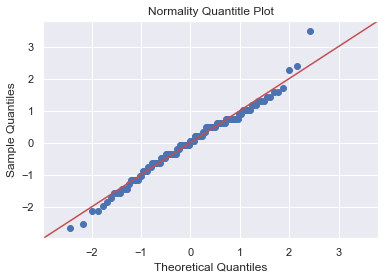

In [12]:
#calc zscores of temp
zscores = zscore(df['temperature'])

#plot normality quantile plot
_ = sm.qqplot(zscores, line='45')
_ = plt.title('Normality Quantitle Plot')
plt.show()

### Conclusion:
-  The histagram showed roughly a bell curve shape, with the mean close to the apex and samples rapidly dropping off further from the mean
-  The SciPy NormalTest method showed a p-value of **0.25** (above our 0.05 threshold)
-  The ECDF chart and 68% and 95% rule test results showed close tracking with a normal distribution and data within
range of 2 and 4 standard deviations around the mean
-  And lastly, the Normality Quantile plot showed the sample data falling on the line of normal distibution

<br>With all this data, we can determine with **95%** confidence that our temperature data are **normally 
distribution**. In other words, we will **NOT** reject the null hypothesis.

### **Question 2: Is the sample size large? Are the observations independent?**

In [13]:
n = len(df)
n

130

The  number of samples, at **130**, is greater than the standard 30 samples deemed to be required by the Central Limit Theorem to be considered a 
large, significant sample size. 
<br>**Note**: The sample size of **130** represent a very small percentage of the actual population, 
which could amplify any sampling bias.

### **Are the observations independent? **
Each sample, according to the documentation by Shoemaker (https://ww2.amstat.org/publications/jse/v4n2/datasets.shoemaker.html)
indicates that the samples were taken from 130 **different** subjects, which would make each measurement independent of 
the other measurements taken, thus making these observations **independent**.  

**Note**: region, date/time, or a number of other factors could bias this proportionally small data set.

### **Question 3: Is the true population mean really 98.6 degrees ($^\circ$F)?**

Frequentist statistical testing:
-  **Would you use a one-sample or two-sample test? Why?**
<br>For this example, we will conduct a one-sample test, since we are comparing a sample mean to the presumed 
population mean, and we do not know the population standard deviation.  A two-sample test is used when you have
two independent sample populations and want to compare whether the average difference between the populations is 
significant or due to random chance.

-  **In this situation, is it appropriate to use the t or z statistic?**
<br>In this example, it is proper to use a t-statistic, since the population standard deviation is unknown,
but seeing that the sample size is large (greater than 30, and thus satisfying the conditions for applying Central 
Limit Theorem) we could use the Z-statistic and both calculations would most likely be very close.

**Null Hypothesis**: the population mean temperature is 98.6 F 
<br>**Alternate Hypothesis**: the population mean temperature ≠ 98.6 F

In [29]:
#calculate one-sample t-test:
t, p = stats.ttest_1samp(df.temperature, 98.6)

print('t-statistic:', t)
print('p-value:', p)

t-statistic: -5.4548232923645195
p-value: 2.4106320415561276e-07


To understand the math behind the t-statistic test:

In [35]:
true_mean = 98.6
sample_mean = np.mean(df['temperature'])
sample_std = np.std(df['temperature'])
#calc standard error of the mean (done since std dev of population is unknown)
sigma_x = sample_std/np.sqrt(len(df))
#can also be done using stats package
sigma_x_stats  = stats.sem(df['temperature'])

print('Sample mean: \t\t', sample_mean)
print('Sample std dev: \t', sample_std)
print('Sigma X: \t\t', sigma_x)
print('Sigma X (stats): \t', sigma_x_stats)

Sample mean: 		 98.24923076923075
Sample std dev: 	 0.730357778905038
Sigma X: 		 0.06405661469519337
Sigma X (stats): 	 0.06430441683789102


In [30]:
z = (98.6 - sample_mean) / sigma_x
p = (1-stats.norm.cdf(z))*2
print('t-statistic: ', t)
print('p-value: ', p) #slightly different, possibly due to rounding?

t-statistic:  -5.4548232923645195
p-value:  4.352315174926957e-08


Let's run a Bootstrap hypothesis test and compare results:

In [17]:
def replicate(data, function):
    """Return resampled data array of the function passed in."""
    
    # Create the resampled array and return the statistic of interest:
    return function(np.random.choice(data, size=len(data)))


def draw_replicates(data, function, size=1):
    """Draw bootstrap replicates.  Return array of replicate values."""

    # Initialize array of replicates:
    replicates = np.empty(size)

    # Generate replicates:
    for i in range(size):
        replicates[i] = replicate(data, function)

    return replicates

In [18]:
# Seed the random number generator:
np.random.seed(42)

# Make an array of translated temperatures:
translated_temps = df.temperature - np.mean(df['temperature']) + 98.6

# Draw bootstrap replicates of translated temperatures:
translated_replicates = draw_replicates(translated_temps, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temperature mean:
p = np.sum(translated_replicates <= np.mean(df['temperature'])) / len(translated_replicates)

# Print the p-value:
print('p-value =', p)

p-value = 0.0


### Bootstrapping method conclusion:

In every test the p-value is significantly less than 0.01, so the null hypothesis is **rejected**. There is sufficient 
evidence to warrant rejection of the claim that the true population mean is the conventional normal human body 
temperature of 98.6°F.

### Finally,let's run a z-statistical test and see if they differ:

In [31]:
z_score, z_pval = ztest(df['temperature'],value=98.6)
print('The Z-Statistic is %d with a p-value of %s' %(abs(z_score),z_pval))

The Z-Statistic is 5 with a p-value of 4.9021570141012155e-08


### Z-statistic Conclusion:

We see that the z-statistic is **5** std dev, outside of the **95%** CI, and the p-value is even smaller, matching the above
conclusion that the null hypothesis can be rejected.

### Conclusion:

T-statistic result is **-5.45**. This means that we would observe a mean of 98.6 at 5.45 standard 
deviations from our sample mean.  This is outside the range of a 95% confidence interval, and suggests the null
hypothesis can be rejected.  To further support this, the p-value is very low, also suggesting the null hypothesis
can be **rejected**, i.e. 98.6 F is NOT the mean body temperature.

## **Question 4: Draw a small sample of size 10 from the data and repeat both frequentist tests.**

### Which one is the correct one to use?
This test meets criteria for a **t-test**,  because the population standard deviation is unkown and the sample size of **10** is small.

In [20]:
# Seed the random number generator:
np.random.seed(15)

# Draw a random sample of 10 from the temperature data:
sample = np.random.choice(df.temperature, size=10)
sample

array([98.4, 97.9, 97.1, 98.7, 98.2, 98.4, 98.2, 98.8, 96.7, 96.4])

In [32]:
# calc t-stat and p-value of a one sample t-test:
t, p = stats.ttest_1samp(sample, 98.6)

print('t-statistic:', t)
print('p-value:', p)

t-statistic: -2.6882644585784705
p-value: 0.024867110651187487


In [22]:
# Calculate and save z-statistic:
z = (np.mean(sample) - 98.6) / (np.std(sample)/np.sqrt(len(sample)))

# Calculate and save p-value:
p = stats.norm.cdf(z) * 2

# Print the values for z and p:
print('z-statistic:', z)
print('p-value:', p)

z-statistic: -2.833679547329114
p-value: 0.004601545004804199


Print the quantiles of the t-distribution corresponding to a **95%** CI and degrees of freedom:

In [23]:
print((stats.t.ppf(q=0.025, df=10-1)), (stats.t.ppf(q=0.975, df=10-1)))

-2.262157162740992 2.2621571627409915


Print the quantiles of the t-distribution corresponding to a **99.5%** CI and degrees of freedom:

In [24]:
print((stats.t.ppf(q=0.0005, df=10-1)), (stats.t.ppf(q=0.9995, df=10-1)))

-4.780912585933472 4.7809125859335495


### What do you notice? What does this tell you about the difference in application of the t  and z statistic?

The test statistic, **-2.688**, falls outside the t-distribution corresponding to a **95%** CI, but **not 99.9%**. 

The p-value for the z-test is below both significance levels, but the p-value for the t-test indicates significance only at the 95% level. 

Both tests provide evidence to reject the null hypothesis. The difference in results reflects the nature of the two distributions. The t-distribution is wider so there is more variability. This makes the t-test less sensitive.

### **Question 5: At what temperature should we consider someone's temperature to be "abnormal"?**

Let's first calculate the true mean temperature with a confidence interval of 95%:

In [25]:
z0 = stats.norm.ppf(0.975)

upper_temp = sample_mean + z0*sigma_x #sigma_x is std error of mean, calc'd above
lower_temp = sample_mean - z0*sigma_x

lower_temp, upper_temp

(98.12368211145662, 98.37477942700488)

Check the above calc using scipy.stats.norm.interval method:

In [26]:
stats.norm.interval(0.95,np.mean(df['temperature']),stats.sem(df['temperature']))

(98.12319642818163, 98.37526511027987)

Bootstrap method:

In [27]:
# Seed the random number generator:
np.random.seed(15)

# Draw bootstrap replicates of temperatures:
replicates = draw_replicates(df.temperature, np.mean, 10000)

# Compute the 99.9% confidence interval:
CI = np.percentile(replicates, [0.05, 99.95])
print('99.9% Confidence Interval:', CI)

99.9% Confidence Interval: [98.04384577 98.45923154]


### **Conclusion:**
the normal range of mean temperature with a **95%** CI is **98.12-98.38**$^\circ$F. The **99.9%** CI shows a range of **98.04-98.46**$^\circ$F.

### **Question 6: Is there a significant difference between males and females in normal temperature?**

In [28]:
#separate the data along gender
male_temps = df.temperature[df.gender == 'M']
female_temps = df.temperature[df.gender == 'F']

print('Mean body temp of male samples: ', np.mean(male_temps))
print('Mean body temp of female samples: ', np.mean(female_temps))

#Independent samples t-test
gender_ttest, gender_pval = stats.ttest_ind(a=male_temps, b=female_temps, equal_var=False)
print('The T-Statistic is %d with a p-value of %s' %(abs(gender_ttest), gender_pval))

Mean body temp of male samples:  98.10461538461537
Mean body temp of female samples:  98.39384615384614
The T-Statistic is 2 with a p-value of 0.023938264182934196


### What testing approach did you use and why?
we can use an **independent samples t-test** as we are comparing the means from two samples.

In [ ]:
### Write a story with your conclusion in the context of the original problem.

**Null Hypothesis**: Normal Male temperature = Normal Female Temperature
**<br>Alternative Hypothesis**: Normal Male temperature ≠ Normal Female Temperature

The t-test statistic value was > 1.96 standard deviations of the 95% confidence level, and the p-value was > than 0.0

The null hypothesis should be **rejected** in favor of the alternative which suggests a statistically 
significant difference between males and females.  This is supported by a relatively small p-value.